# Dataset Preparation


In [3]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

def load_images_and_labels(image_dir, label_dir, image_size=(128, 128)):
    images = [] 
    labels = []

    #go through the image files in the folder
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpeg'):
            #make the path for the image and that images label
            img_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, filename.replace('.jpeg', '.txt'))

            # Load and resize image 
            img = imread(img_path) 
            #images might come in many sizes, making them consitent makes feature extraction easier 
            #also normalises to help in our model development
            img_resized = resize(img, image_size, anti_aliasing=True) 
            images.append(img_resized)  # add to the list 

            # Read label
            with open(label_path, 'r') as f:
                label = int(f.read().strip()) #read the label and convert it to an interger
            labels.append(label) # add to the list 

    #converts the two lists, image and label into numpy arrays 
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64)

def prepare_datasets(
    train_image_path, train_label_path,
    test_image_path, test_label_path,
    image_size=(128, 128),
    val_split=0.2,
    seed=42
):
    # Load the whole training set both labels and images, they are resized and normalised 
    X_train_full, y_train_full = load_images_and_labels(train_image_path, train_label_path, image_size)
    
    #same with the test set 
    X_test, y_test = load_images_and_labels(test_image_path, test_label_path, image_size)

    # Split training data into train validation, standard split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_split, random_state=seed, stratify=y_train_full #ensure smae label distribution with stratify
    )

    #sanity check
    print(f"Train: {X_train.shape}, {y_train.shape}")
    print(f"Validation: {X_val.shape}, {y_val.shape}")
    print(f"Test: {X_test.shape}, {y_test.shape}")

    return X_train, y_train, X_val, y_val, X_test, y_test

load training and test data, resize, normalise, split the data into the sets, and returns as numpy


In [4]:
train_image_path = '/Users/david/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents – David’s MacBook Pro/university/year 3/Computer vision/cw/CV2024_CW_Dataset/train/images'
train_label_path = '/Users/david/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents – David’s MacBook Pro/university/year 3/Computer vision/cw/CV2024_CW_Dataset/train/labels'
test_image_path = '/Users/david/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents – David’s MacBook Pro/university/year 3/Computer vision/cw/CV2024_CW_Dataset/test/images'
test_label_path = '/Users/david/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents – David’s MacBook Pro/university/year 3/Computer vision/cw/CV2024_CW_Dataset/test/labels'

X_train, y_train, X_val, y_val, X_test, y_test = prepare_datasets(
    train_image_path, train_label_path,
    test_image_path, test_label_path,
    image_size=(128, 128)
)

Train: (1915, 128, 128, 3), (1915,)
Validation: (479, 128, 128, 3), (479,)
Test: (458, 128, 128, 3), (458,)


# class encompassing all of the evaluation metrics i will use


In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

class ModelEvaluator:
    def __init__(self, class_names=["No Mask", "Mask", "Incorrect"]):
        # instead of having the 0,1,2 labels usd actual descriptors for clarity 
        self.class_names = class_names

    def evaluate(self, y_true, y_pred, model_name="Model", verbose=True):
      
        results = {}

        # accuracy score 
        acc = accuracy_score(y_true, y_pred)
        results['accuracy'] = acc

        # Macro = equally weighs all classes (sensitive to minority classes)
        results['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        results['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        results['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # Micro = globally computed over all samples for class imbalance)
        results['precision_micro'] = precision_score(y_true, y_pred, average='micro', zero_division=0)
        results['recall_micro'] = recall_score(y_true, y_pred, average='micro', zero_division=0)
        results['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)

        # Weighted = like macro but adjusts for class imbalance by using class frequencies
        results['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        if verbose:
            print(f"\nEvaluation results for {model_name}:")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score (macro): {results['f1_macro']:.4f}")
            print(f"F1 Score (weighted): {results['f1_weighted']:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

        return results

    def plot_confusion_matrix(self, y_true, y_pred, title="Confusion Matrix"):
        #plot a confusion matrix 

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def visualize_predictions(self, images, y_true, y_pred, n_samples=4):
        
        #Display somerandom image samples with ground truth and predicted labels, this will be useful for examples if i use them in the report
        indices = random.sample(range(len(images)), n_samples)
        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(indices):
            img = images[idx]
            true_label = self.class_names[y_true[idx]]
            pred_label = self.class_names[y_pred[idx]]
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.tight_layout()
        plt.show()
#initialise evaluator
evaluator = ModelEvaluator(class_names=["No Mask", "Mask", "Incorrect"])

## why i chose each of the metrics:



### macro 
shows how the model works on all classes equally
### micro 
a more broad perspective, this is good for if there is an imbalance
### weighted
 is the middle ground balancing macro with the proportions of the classes 

### Accuracy


Overall correctness of the model so kind of essential
kind of limited if classes are imbalanced 

### Precision 

measure for how many predicted positives were actually correct

### Recall

measure how many ACTUAL postives were caught 

### F1 score 

combination of precision and recall, better for imbalanced classes and good to check robustness

### classification report

joined breakeddown of the previous metrics, good to find underperforming class

### Confusion matrix

visualsing the results so that we can see where the model confused things like incorrectly worn mask  with no mask at all

### visualise predictions

will help with examples in the report 

# Models

##  HOG + SVM 

In [ ]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random

# extracting HOG Features 
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    hog_features = []
    for img in images:
        # Convert to grayscale for HOG
        gray_img = np.mean(img, axis=2) #convert to grayscale
        #calc HOG descriptor for the image 
        features = hog(
            gray_img,
            orientations=orientations, #number of orientation bins 
            pixels_per_cell=pixels_per_cell, #size of the cell
            cells_per_block=cells_per_block, #griup for local contrast
            block_norm='L2-Hys', #method for normalization
            feature_vector=True #make sure i output a flat vector 
        )
        #store the descriptor
        hog_features.append(features) 
    return np.array(hog_features) #2d array, each row is a HOG feature

# training
def train_hog_svm(X_train, y_train):
    print("Extracting HOG features for training...")
    hog_train = extract_hog_features(X_train)

    print("Training SVM classifier...")
    #rbf kernel handles non linea decision boundaries 
    clf = SVC(kernel='rbf', C=10, gamma=0.01)
    clf.fit(hog_train, y_train)
    return clf #the trained model

# evaalujate the svm 
def evaluate_hog_svm(clf, X, y, split_name="Validation"):
    #using the validation set for now so i can see how it performs on unseen data
    print(f"\n Extracting HOG features for {split_name} set...")
    hog_features = extract_hog_features(X)

    print(f"Predicting {split_name} set...")
    y_pred = clf.predict(hog_features)

    # Use evaluator to get and print detailed metrics
    evaluator.evaluate(y, y_pred, model_name=f"HOG + SVM ({split_name})")
    evaluator.plot_confusion_matrix(y, y_pred, title=f"HOG + SVM - {split_name} Confusion Matrix")

    return y_pred #the labels our model predicted

# visualise some results which were predicted
def show_predictions(X, y_true, y_pred, n_samples=4):
    evaluator.visualize_predictions(X, y_true, y_pred, n_samples=n_samples)

### now lets run it 

Extracting HOG features for training...
Training SVM classifier...

 Extracting HOG features for Validation set...
Predicting Validation set...

Evaluation results for HOG + SVM (Validation):
Accuracy: 0.8622
F1 Score (macro): 0.5194
F1 Score (weighted): 0.8319

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.85      0.37      0.52        75
        Mask       0.86      0.99      0.92       388
   Incorrect       1.00      0.06      0.12        16

    accuracy                           0.86       479
   macro avg       0.90      0.48      0.52       479
weighted avg       0.87      0.86      0.83       479



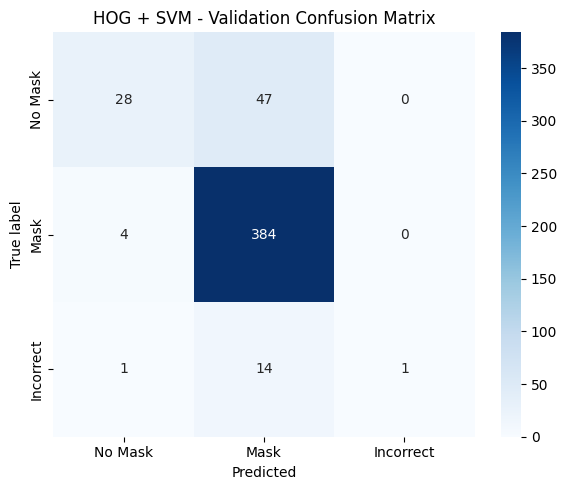

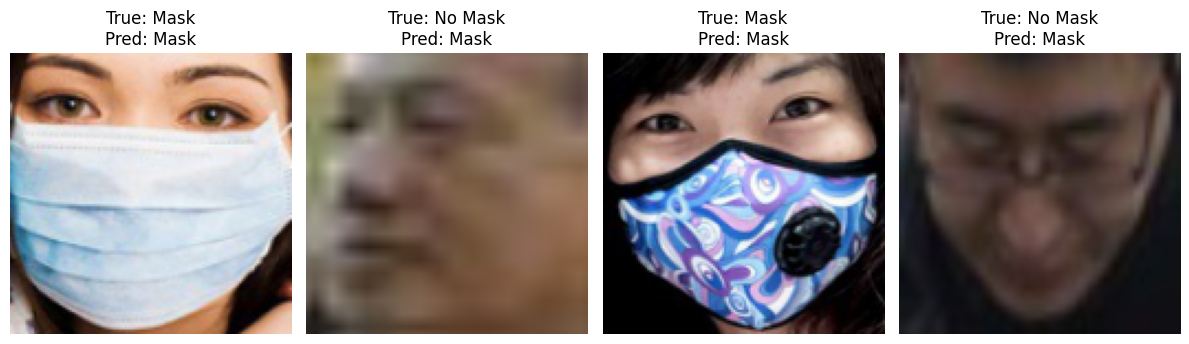

In [18]:

# train on training set
hog_svm_model = train_hog_svm(X_train, y_train)

# Evaluate only on validation set
val_preds = evaluate_hog_svm(hog_svm_model, X_val, y_val)

# Visualize some results from validation set
show_predictions(X_val, y_val, val_preds)

## SIFT + BoVW + MLP

In [15]:
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier

def extract_sift_descriptors(images, max_features_per_image=100):
   
    sift = cv2.SIFT_create() #feature extracture, takes keypoints and descriptors 
    descriptors_list = []
    valid_indices = []

    for idx, img in enumerate(tqdm(images, desc="Extracting SIFT descriptors")):
        #converting the previously normalised float back to 8-bit with unit8 for OpenCV
        gray = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY) #convert to grayscale 
        _, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is not None:
            #limit descriptors to contorl computational time
            descriptors_list.append(descriptors[:max_features_per_image]) 
            valid_indices.append(idx)  # record that image worked

    return descriptors_list, valid_indices #return descriptors and indices that worked 

def build_visual_vocabulary(descriptor_list, vocab_size=100):
    all_descriptors = np.vstack(descriptor_list) #all the descriptors from the images into a single array

    #using kMeans group descriptors inot clusters
    kmeans = MiniBatchKMeans(
        n_clusters=vocab_size, #numb of visual words
        batch_size=1000, #batch size, 1000 is a balance between fast and scalable
        random_state=42#reproducibility seed 
        ) 
    kmeans.fit(all_descriptors)#fit the model to all the descriptors 
    return kmeans #returning the trained vocab model

def compute_bovw_histograms(descriptor_list, kmeans_model):
    vocab_size = kmeans_model.n_clusters #number of bins in the bag of visual words histogram
    histograms = []

    for descriptors in descriptor_list:
        histogram = np.zeros(vocab_size) #initialise histogram with zero
        if descriptors is not None:
            words = kmeans_model.predict(descriptors) #each descriptor is assigned to a visual word
            for w in words:
                histogram[w] += 1 #increment the count in corresponding histogram bin
        histograms.append(histogram) # add the histogram to the list

    return np.array(histograms) #list into array

def train_sift_mlp(X_train, y_train, vocab_size=100):
    print("Extracting SIFT features...")
    #retrieve the usable descriptors and indicies
    descriptors_list, valid_indices = extract_sift_descriptors(X_train)

    #filter the labels corresponding to valid images
    y_train_filtered = y_train[valid_indices]

    print("Building visual vocabulary...")
    kmeans_model = build_visual_vocabulary(descriptors_list, vocab_size=vocab_size)

    #features converted to fixed length histograms
    print("Building BoVW histograms...")
    bovw_train = compute_bovw_histograms(descriptors_list, kmeans_model)

    print("Training MLP classifier...")
    clf = MLPClassifier(
        hidden_layer_sizes=(128,),#one hidden layer with 128 neuronr
        max_iter=500, # 500 training iterations
        random_state=42 #for reproducibility
        )
    clf.fit(bovw_train, y_train_filtered) #training the MLP on BoVW features and label

    return clf, kmeans_model  # return both for reuse on evaluation

def evaluate_sift_mlp(clf, kmeans_model, X_val, y_val):
    descriptors_val, val_indices = extract_sift_descriptors(X_val) #extract descriptors from the validation set
    y_val_filtered = y_val[val_indices] #filter out the labels for usable validation images

    bovw_val = compute_bovw_histograms(descriptors_val, kmeans_model) #convert the data in the validation files to BoVW vectors
    y_pred = clf.predict(bovw_val) #predict

    evaluator.evaluate(y_val_filtered, y_pred, model_name="SIFT + BoVW + MLP") 
    evaluator.plot_confusion_matrix(y_val_filtered, y_pred, title="SIFT + BoVW + MLP - Validation Confusion Matrix")

    return y_pred

def show_predictions(X_val, y_val, y_pred, n_samples=4):
    #visualise some examples
    evaluator.visualize_predictions(X_val, y_val, y_pred, n_samples=n_samples)

Extracting SIFT features...


Extracting SIFT descriptors: 100%|██████████| 1915/1915 [00:03<00:00, 513.19it/s]


Building visual vocabulary...
Building BoVW histograms...
Training MLP classifier...


Extracting SIFT descriptors: 100%|██████████| 479/479 [00:01<00:00, 439.26it/s]



Evaluation results for SIFT + BoVW + MLP:
Accuracy: 0.8121
F1 Score (macro): 0.4496
F1 Score (weighted): 0.7924

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.52      0.41      0.46        75
        Mask       0.86      0.92      0.89       388
   Incorrect       0.00      0.00      0.00        16

    accuracy                           0.81       479
   macro avg       0.46      0.45      0.45       479
weighted avg       0.78      0.81      0.79       479



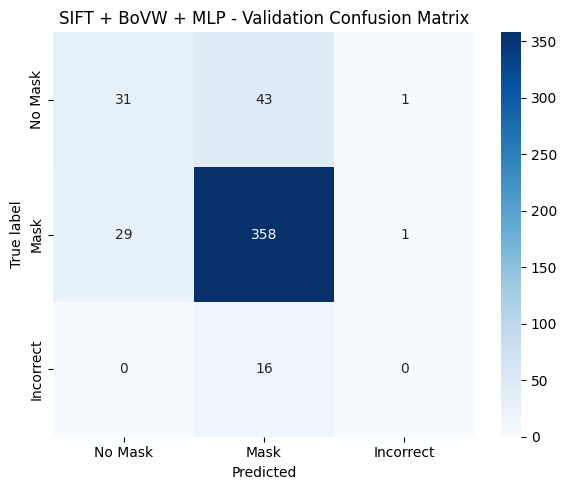

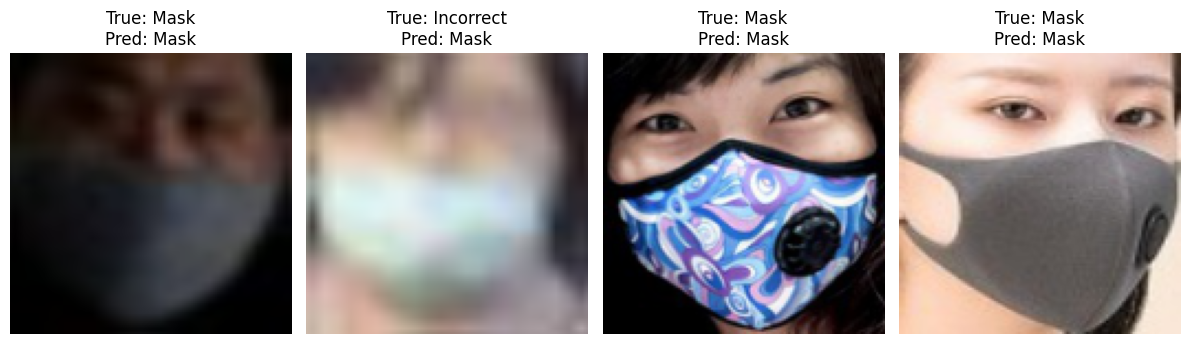

In [16]:

# Train SIFT + BoVW + MLP
sift_mlp_model, sift_kmeans = train_sift_mlp(X_train, y_train, vocab_size=100)

# Evaluate on validation set
val_preds_sift = evaluate_sift_mlp(sift_mlp_model, sift_kmeans, X_val, y_val)

# Visualize
show_predictions(X_val, y_val, val_preds_sift)

## First CNN

In [ ]:
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.api.utils import to_categorical
from keras.api.callbacks import EarlyStopping
import numpy as np

def build_cnn(input_shape=(128, 128, 3), num_classes=3):
    model = Sequential() #using a sequential model
    #initialise a stack of layers 

    # First conv layer, apply 32 filters of size 3x3
    # ReLU activation introduces non linearity
    # first layer where input shape is defined
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

    #reduces spatial dimensions by 2x, makes feature map smaller and more abstract
    model.add(MaxPooling2D(pool_size=(2, 2))) 

    #randomly turn off 1/4 of the neurons in training 
    model.add(Dropout(0.25))  # prevent overfitting by forcing robustness 

    #the second layer now has double the filters for deeper feature learning 
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    

    #once again double the filters for even deeper learning 
    model.add(Flatten())  # Flatten ouutputs of previous layers to 1D before passing to fully connected layer
    model.add(Dense(128, activation='relu'))  # Fully connected layer, relu helps the network learn non linear boundaries 
    model.add(Dropout(0.5)) #stronger regularization to prevent overfitting before output layer
    model.add(Dense(num_classes, activation='softmax'))  # final output layer has a neuron ofr each class, softmax converts scores to class probs

    model.compile(
        optimizer='adam', #adaptive learning rate optimizer
        loss='categorical_crossentropy', #good for mulit class classification
        metrics=['accuracy'] #keep track during training and evaluation
    )

    return model

def train_cnn(X_train, y_train, X_val, y_val, epochs=30, batch_size=32):
    model = build_cnn(input_shape=X_train.shape[1:], num_classes=3) #buliding the cnn with the input data, and the numb of classes from the data

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) #stops training early if val loss doesnt improve in 3 epochs, avoid overfitting

    # Convert labels to categorical (1 -> [0, 1, 0])
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    history = model.fit(
        X_train, y_train_cat, 
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size, #how many samples are processed at a time
        verbose=1, #progress bar 
        callbacks=[early_stop] #early stopping
    )

    return model, history

def evaluate_cnn(model, X_val, y_val):
    y_pred_prob = model.predict(X_val)  # probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax outputs to class indices

    # Using evaluator class for metrics and confusion matrix
    evaluator.evaluate(y_val, y_pred, model_name="Simple CNN")
    evaluator.plot_confusion_matrix(y_val, y_pred, title="Simple CNN - Validation Confusion Matrix")

    return y_pred

def show_predictions(X_val, y_val, y_pred, n_samples=4):
    #preview of some predictions 
    evaluator.visualize_predictions(X_val, y_val, y_pred, n_samples=n_samples)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7475 - loss: 1.3563 - val_accuracy: 0.9061 - val_loss: 0.4062
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9208 - loss: 0.2701 - val_accuracy: 0.9040 - val_loss: 0.3619
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9300 - loss: 0.2232 - val_accuracy: 0.8789 - val_loss: 0.3548
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9388 - loss: 0.2036 - val_accuracy: 0.9311 - val_loss: 0.2135
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9472 - loss: 0.1816 - val_accuracy: 0.9374 - val_loss: 0.1961
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9497 - loss: 0.1759 - val_accuracy: 0.9395 - val_loss: 0.1941
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9484 - loss: 0.1717 - val_accuracy: 0.9374 - val_loss: 0.1763
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.9517 - loss: 0.1534 - val_accuracy: 0.9415 - val_loss: 

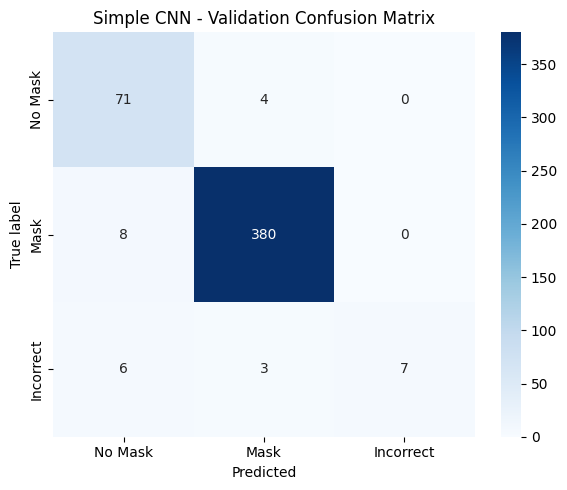

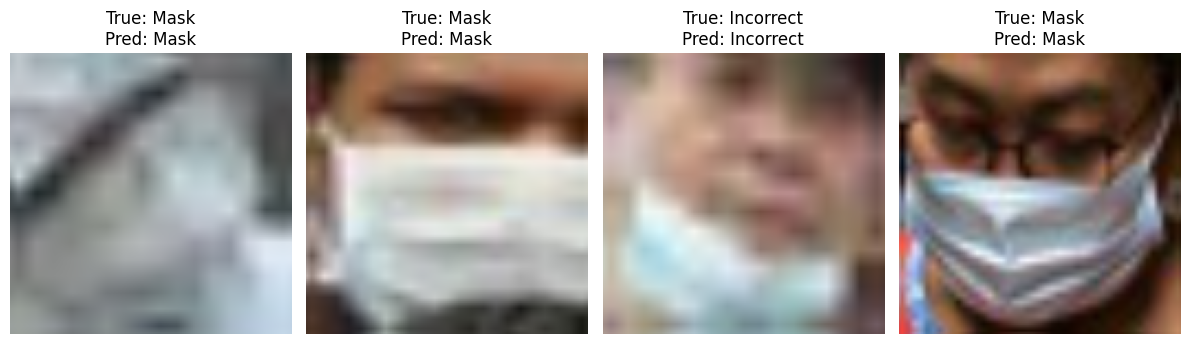

In [27]:
# Train CNN
cnn_model, cnn_history = train_cnn(X_train, y_train, X_val, y_val)

# Evaluate
y_pred_cnn = evaluate_cnn(cnn_model, X_val, y_val)

# Visualize
show_predictions(X_val, y_val, y_pred_cnn)